In [1]:
# mount google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
import pandas as pd
import numpy as np
import os

from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten, Input, Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling2D, MaxPooling1D, Dense, GlobalMaxPooling1D, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import librosa
from sklearn.utils import shuffle
import pickle

# download from:
# https://github.com/SenticNet/MELD/blob/master/baseline/baseline.py

DATA_PATH = '/content/gdrive/Team Drives/IKE Data/Emotion detection'
#DATA_PATH = 'data'
DATASET_PATH = os.path.join(DATA_PATH, 'dataset_combined.pkl')
NUM_CLASSES = 7

train = pd.read_csv(os.path.join(DATA_PATH, 'emorynlp_train_final.csv'))
val = pd.read_csv(os.path.join(DATA_PATH, 'emorynlp_dev_final.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'emorynlp_test_final.csv'))
train.head()


,Utterance,Speaker,Emotion,Scene_ID,Utterance_ID,Season,Episode,Start_Time,End_Time
0,"What you guys don't understand is, for us, kis...",['Monica Geller'],Joyful,1,1,1,2,00:00:02.877,00:00:07.548
1,"Yeah, right!.......Y'serious?",['Joey Tribbiani'],Neutral,1,2,1,2,00:00:04.504,00:00:07.548
2,"Oh, yeah!",['Phoebe Buffay'],Joyful,1,3,1,2,00:00:07.924,00:00:09.508
3,Everything you need to know is in that first k...,['Rachel Green'],Powerful,1,4,1,2,00:00:11.970,00:00:17.683
4,Absolutely.,['Monica Geller'],Powerful,1,5,1,2,00:00:14.139,00:00:15.097


In [4]:
# create tokenizer and fit on train
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train['Utterance'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5128 unique tokens.


In [17]:
embeddings_index = {}
f = open(os.path.join(DATA_PATH, 'glove.6B', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [21]:
def preprocess(data, folder, tokenizer):
    data['label'] = data['Emotion'].astype('category').cat.codes

    labels = []
    spectrums = []
    texts = []

    for index, row in data.iterrows():
        filename = 'sea%d_ep%d_sc%d_utt%d.wav' % (row.Season, row.Episode, row.Scene_ID, row.Utterance_ID)
        path = os.path.join('data', 'audio', folder, filename)
        if not os.path.isfile(path):
            print('file does not exist', path)
            continue

        sample, sr = librosa.load(path, 24000, duration=2)
        assert sr == 24000, 'sample rate incorrect'

        padded_sample = np.zeros(48001, dtype='float32')
        padded_sample[:sample.shape[0]] = sample

        melgram = librosa.feature.melspectrogram(padded_sample, sr, n_fft=512, hop_length=256, n_mels=96)
        log_melgram = librosa.amplitude_to_db(melgram)
        log_melgram = np.expand_dims(log_melgram, axis=-1)
        assert log_melgram.shape == (96, 188, 1), 'mel shape incorrect'

        labels.append(row.label)
        spectrums.append(log_melgram)
        texts.append(row['Utterance'])

        if index % 500 == 0:
            print('loaded %d from %d rows' % (index, len(data)))
        
    # create np array for audio
    x1 = np.stack(spectrums)
    
    # create np array for texts
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=33)
    x2 = np.stack(padded)
    
    # create np array for labels
    y = np.stack(labels)
    y = to_categorical(y, num_classes=NUM_CLASSES)
    
    # shuffle
    x1, x2, y = shuffle(x1, x2, y, random_state=42)
    
    return [x1, x2], y

if os.path.isfile(DATASET_PATH):
    print("loading from cache")
    with open(DATASET_PATH, 'rb') as handle:
        train_x, train_y, test_x, test_y, val_x, val_y, word_index = pickle.load(handle)

else:        
    train_x, train_y = preprocess(train, 'train', tokenizer)
    test_x, test_y = preprocess(test, 'test', tokenizer)
    val_x, val_y = preprocess(val, 'dev', tokenizer)
    with open(DATASET_PATH, 'wb') as handle:
        pickle.dump((train_x, train_y, test_x, test_y, val_x, val_y, word_index), handle)    

print(train_x[0].shape, train_x[1].shape, train_y.shape)        

loading from cache
(7548, 96, 188, 1) (7548, 33) (7548, 7)


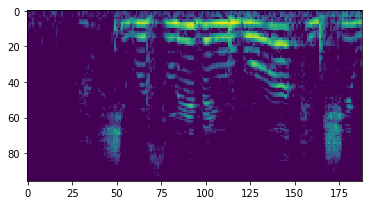

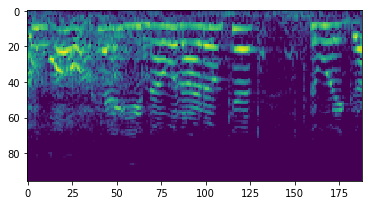

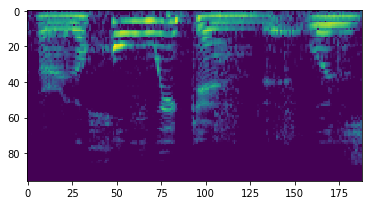

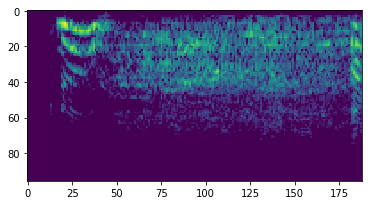

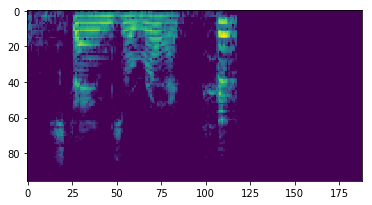

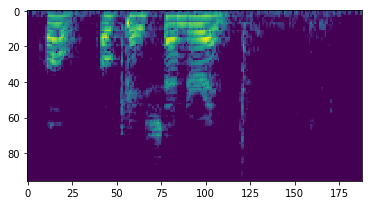

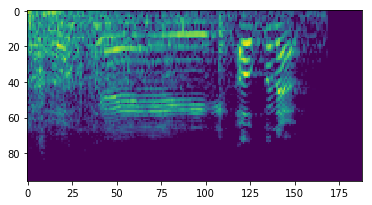

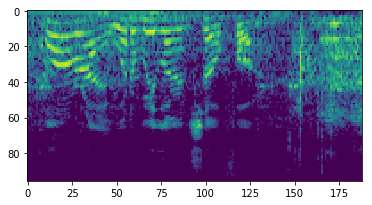

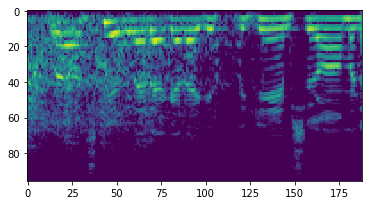

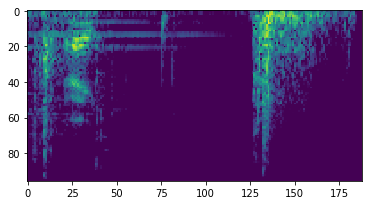

In [15]:
# show some spectrograms
for i in range(0, 10):
    plt.imshow(np.squeeze(train_x[0][i]))
    plt.show()

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
print (train_x[0].shape, train_x[1].shape, train_y.shape)

(7548, 96, 188, 1) (7548, 33) (7548, 7)


In [0]:
# from imblearn.keras import BalancedBatchGenerator
# # from imblearn.under_sampling import RandomUnderSampler
# from imblearn.under_sampling import NearMiss

# train_gen = BalancedBatchGenerator(
#     train_x[0], train_y, sampler=NearMiss(), batch_size=32, random_state=42)

# x, y = next(train_gen)
# print (x[0].shape, x[1].shape, y.shape)

In [0]:
# define audio model
def audio_model(x):
  x = Conv2D(32, 5, activation='relu')(x)
  x = MaxPooling2D(3)(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Conv2D(64, 5, activation='relu')(x)
  x = MaxPooling2D(3)(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Conv2D(128, 3, activation='relu')(x)
  x = GlobalMaxPooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  return x

In [0]:
# define text model
def text_model(x):
  x = Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=33, trainable=False)(x)
  x = Conv1D(128, 5, activation='relu')(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.3)(x)
  x = Conv1D(128, 5, activation='relu')(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.3)(x)
  x = Conv1D(128, 5, activation='relu')(x)
  x = GlobalMaxPooling1D()(x)
  x = Dropout(0.3)(x)
  return x

In [30]:
# text model
text_input = Input(shape=(33,), dtype='int32')
text_output = text_model(text_input)

# final prediction layers
x = Dense(256, activation='relu')(text_output)
x = Dropout(0.2)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(text_input, x)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
model.summary()

model.fit(train_x[1], train_y, validation_data=(val_x[1], val_y), epochs=20, verbose=1)
print("Accuracy: %.2f" % model.evaluate(test_x[1], test_y)[1])

# base: 0.31

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 33)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 33, 100)           512900    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 29, 128)           64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 128)           82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
__________

KeyboardInterrupt: ignored

In [33]:
# audio model
audio_input = Input(shape=train_x[0].shape[1:])
audio_output = audio_model(audio_input)

# final prediction layers
x = Dense(256, activation='relu')(audio_output)
x = Dropout(0.2)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(audio_input, x)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
model.summary()

model.fit(train_x[0], train_y, validation_data=(val_x[0], val_y), epochs=20, verbose=1)
print("Accuracy: %.2f" % model.evaluate(test_x[0], test_y)[1])

# base: 0.28

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 96, 188, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 92, 184, 32)       832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 61, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 61, 32)        128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 61, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 57, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 19, 64)         0         
__________

In [35]:
# combined model
text_input = Input(shape=(33,), dtype='int32')
text_output = text_model(text_input)

audio_input = Input(shape=train_x[0].shape[1:])
audio_output = audio_model(audio_input)

# final prediction layers
x = Concatenate()([audio_output, text_output])
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model([audio_input, text_input], x)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
model.summary()

model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=20, verbose=1)
print("Accuracy: %.2f" % model.evaluate(test_x, test_y)[1])

# base: 0.29

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 96, 188, 1)   0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 92, 184, 32)  832         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 30, 61, 32)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
batch_norm